Baseline for the HAHA [challenge 2019](https://competitions.codalab.org/competitions/22194) 

After you register for the challenge, you will get access to the training data titled `haha_2019_train.csv`

Based on [NB-SVM baseline](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pdb import set_trace

### Reading the texts

In [3]:
all_texts_df = pd.read_csv('./data/haha_2019_train.csv')

In [4]:
all_texts_df.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,705196579758583809,Niveles de retraso mental: \r\n\r\n— Bajo.\r\n...,1,1,2,2,0,0,0,1.5
1,678040651817213952,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5
2,546750892213829633,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.6
3,965807211292364801,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN
4,638403841839484928,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN


In [5]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [6]:
def get_data(all_text_df, rnd_seed=None):
    np.random.seed(rnd_seed if rnd_seed else None)

    idx = np.random.permutation(len(all_texts_df))
    test_cut = int(0.15 * len(idx))
    valid_cut = int(0.15 * len(idx-test_cut))

    df_train = all_texts_df.iloc[idx[:-(valid_cut+test_cut)],:]
    df_test  = all_texts_df.iloc[idx[-(valid_cut+test_cut):-test_cut],:]
    # df_test      = all_texts_df.iloc[idx[-test_cut:],:]
    
    return df_train, df_test

In [7]:
def pr(y_i, y, x):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [8]:
def get_mdl(y, x):
    y = y.values
    r = np.log(pr(1,y,x) / pr(0,y,x))
    m = LogisticRegression(C=4, dual=True, solver='liblinear')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [9]:
label_col = 'is_humor'

all_acc = []
for _ in range(30):
    df_train, df_test = get_data(all_texts_df,None)

    n = all_texts_df.shape[0]
    vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                   min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                   smooth_idf=1, sublinear_tf=1 )
    trn_term_doc = vec.fit_transform(df_train['text'])
    test_term_doc = vec.transform(df_test['text'])

    preds = np.zeros(len(df_test))
    m,r = get_mdl(df_train[label_col], trn_term_doc)
    preds = m.predict_proba(test_term_doc.multiply(r))[:,1]    
    TP = ((preds > 0.5).astype(int) == df_test[label_col].values)
    acc = TP.sum() / len(df_test)
    all_acc.append(acc)
    print(f'Accuracy: {acc}')

Accuracy: 0.8441666666666666
Accuracy: 0.8336111111111111
Accuracy: 0.8397222222222223
Accuracy: 0.8319444444444445
Accuracy: 0.8397222222222223
Accuracy: 0.8463888888888889
Accuracy: 0.8452777777777778
Accuracy: 0.845
Accuracy: 0.8377777777777777
Accuracy: 0.8416666666666667
Accuracy: 0.8297222222222222
Accuracy: 0.8294444444444444
Accuracy: 0.8341666666666666
Accuracy: 0.8433333333333334
Accuracy: 0.8477777777777777
Accuracy: 0.8480555555555556
Accuracy: 0.8458333333333333
Accuracy: 0.8372222222222222
Accuracy: 0.8275
Accuracy: 0.8391666666666666
Accuracy: 0.8302777777777778
Accuracy: 0.8483333333333334
Accuracy: 0.8369444444444445
Accuracy: 0.8494444444444444
Accuracy: 0.8341666666666666
Accuracy: 0.8333333333333334
Accuracy: 0.8380555555555556
Accuracy: 0.8347222222222223
Accuracy: 0.8408333333333333
Accuracy: 0.8422222222222222


count    30.000000
mean      0.839194
std       0.006351
min       0.827500
25%       0.834167
50%       0.839444
75%       0.844792
max       0.849444
dtype: float64

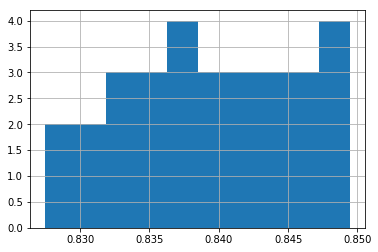

In [10]:
pd.Series(all_acc).hist()
pd.Series(all_acc).describe()